# Test Nonhomogeneous Poisson

In [1]:
# std library
import os
import sys
import json
import random
from datetime import datetime

# third-party
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [2]:
wd = os.getcwd()
current_dir = os.path.dirname(wd + '/')
parent_dir = os.path.dirname(current_dir)

# wd, current_dir, parent_dir
sys.path.append(parent_dir)

# import local modual
from poisson import simulate_nhpp, simulate_hpp

In [3]:
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)

In [4]:
# Set parameter
intensity_effort_ratio = 1.5

In [5]:
# Generate data
## real-time (per hour) daily effort and hourly intensity
ts_effort = np.load('./ts_effort.npy')
intensity = intensity_effort_ratio / 24 * ts_effort
print('Number of time intervals =', intensity.size)
print('max (hour) intensity =', intensity.max())
## interpolate
intensity2 = np.append(intensity, [0])
flt_times2 = np.array(range(len(intensity2))) / (len(intensity2) - 1)
fn_intensity = interp1d(flt_times2, intensity2)
print(intensity2[0], fn_intensity(2.6e-4), intensity2[1])
## generate events
rng_poisson = random.Random(1234)
rng_uniform = random.Random(5678)
events, unthinned, _ = simulate_nhpp(start_time, end_time, fn_intensity, 1.5, rng_poisson, rng_uniform)
print('number of unthinned events =', len(unthinned))
print('number of   thinned events =', len(events))

Number of time intervals = 2160
max (hour) intensity = 1.001183527469498
0.5250639139230147 0.5251321959417738 0.5251854987142526
number of unthinned events = 3172
number of   thinned events = 47


In [6]:
# Save to json file
test_nhpp_data = os.path.join(wd, 'test_nhpp_data.json')
with open(test_nhpp_data, 'w') as f:
	json.dump({
		'hours': int((end_time - start_time).total_seconds() / 3600),
		'effort': ts_effort.tolist(),
		'N': len(events),
		'events': [(t - start_time).total_seconds() / 3600 for t in events],
	}, f, indent=4)

In [7]:
# import cmdstanpy
# cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

In [8]:
# Build model
stan_file_nhpp = os.path.join(wd, 'test_nhpp.stan')
stan_model_nhpp = CmdStanModel(stan_file=stan_file_nhpp)

In [9]:
# Fit data
fit_nhpp = stan_model_nhpp.sample(
	data=test_nhpp_data,
	chains=4,
	iter_warmup=500,
	iter_sampling=1000,
	parallel_chains=4,
	show_console=False,
)

16:55:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:55:53 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
posteriors_r = fit_nhpp.stan_variable('r')
posteriors_r.mean(), posteriors_r.std()

(np.float64(1.5038518262500002), np.float64(0.21898514457835733))

Compare:
- intensity_effort_ratio = 1.5

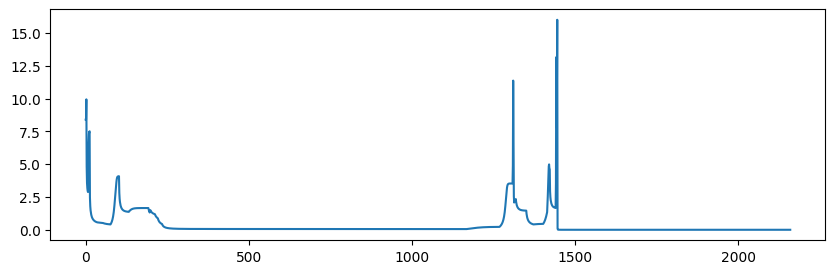

In [12]:
plt.figure(figsize=(10, 3))
plt.plot(ts_effort)
plt.show()